# ***Generate*** the analysis-ready dataset of a selected BGC-Argo float

### <span style="color:red">--- User input begins ---</span>
- `wmoid`: the float's WMO
- `qc2keep`: value(s) of QC flags to be considered valid (\['1','2','5','8'\] is a standard choice, but modify as necessary) 

In [1]:
wmoid = 6903574
qc2keep = ['1','2','5','8']

### <span style="color:red">--- User input ends ---</span>

In [2]:
import xarray as xr
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import generic_filter
import pvlib
import gsw
import scipy
import datetime

### Check for profiles
- make sure that there is a directory named the float WMO (it can be a symbolic link).

In [3]:
pattern = f"{wmoid}/S[RD]{wmoid}_???.nc"
list_file = glob.glob(pattern)
print('There are',len(list_file),'profiles for the selected float.')

There are 200 profiles for the selected float.
['6903574/SD6903574_127.nc', '6903574/SD6903574_067.nc', '6903574/SD6903574_176.nc', '6903574/SD6903574_036.nc', '6903574/SD6903574_185.nc', '6903574/SD6903574_094.nc', '6903574/SD6903574_002.nc', '6903574/SD6903574_142.nc', '6903574/SD6903574_053.nc', '6903574/SD6903574_113.nc', '6903574/SD6903574_103.nc', '6903574/SD6903574_043.nc', '6903574/SD6903574_152.nc', '6903574/SD6903574_012.nc', '6903574/SD6903574_084.nc', '6903574/SD6903574_195.nc', '6903574/SD6903574_026.nc', '6903574/SD6903574_166.nc', '6903574/SD6903574_077.nc', '6903574/SD6903574_137.nc', '6903574/SD6903574_057.nc', '6903574/SD6903574_117.nc', '6903574/SD6903574_006.nc', '6903574/SD6903574_146.nc', '6903574/SD6903574_172.nc', '6903574/SD6903574_032.nc', '6903574/SD6903574_123.nc', '6903574/SD6903574_063.nc', '6903574/SD6903574_090.nc', '6903574/SD6903574_181.nc', '6903574/SD6903574_200.nc', '6903574/SD6903574_191.nc', '6903574/SD6903574_080.nc', '6903574/SD6903574_073.nc', 

### Read all profiles

In [8]:
# list for storing all profiles
juld = [] # date and time
lon = [] # longitude
lat = [] # latitude
pres = [] # pressure level (depth)
varis = ['temp','psal','down','nitr','chla','bbp7','doxy','ph_i'] # shortened names
vars_original = ['TEMP_ADJUSTED','PSAL_ADJUSTED', # original names
                 'DOWNWELLING_PAR_ADJUSTED','NITRATE_ADJUSTED',
                 'CHLA_ADJUSTED','BBP700_ADJUSTED',
                 'DOXY_ADJUSTED','PH_IN_SITU_TOTAL_ADJUSTED']
cmap_vars = ['inferno', 'cividis','viridis','magma','Greens','plasma','Blues','Oranges'] # colormap for each variable
raw = {f"{var}": [] for var in varis} # raw data
qc = {f"{var}": [] for var in varis} # qc flags
qc_valid = {f"{var}": [] for var in varis} # good data
pres_qc_valid = {f"{var}": [] for var in varis} # corresponding pres for good data
npq5_qc_valid = [] # corresponding qc=5 for good chla data (used for identifying whether npq correction is needed)
daytime_valid = []

def calc_solar_elevation(latitude, longitude, utc):
    loc = pvlib.location.Location(latitude, longitude)
    solar_position = loc.get_solarposition(utc)
    solar_zenith = solar_position['zenith'].values[0]  
    solar_elevation = 90 - solar_zenith
    return solar_elevation

# loop over profiles to determine whether to use PRES or PRES_ADJUSTED
for i in range(len(list_file)): 
    # open the netCDF file for each profile
    ds = xr.open_dataset(list_file[i]) 
    if all(np.isnan(ds['PRES_ADJUSTED'][0,:].values)):
        use_pres = True
    # if PRES_ADJUSTED contains values in any single profile, use PRES_ADJUSTED
    else:
        use_pres = False
        break

# loop over profiles
for i in range(len(list_file)): 
    # open the netCDF file for each profile
    ds = xr.open_dataset(list_file[i]) 
    juld.append(ds['JULD'][0].values)
    lon.append(ds['LONGITUDE'][0].values)
    lat.append(ds['LATITUDE'][0].values)
    if use_pres == True:
        pres.append(ds['PRES'][0,:].values)
    elif use_pres == False:
        pres.append(ds['PRES_ADJUSTED'][0,:].values)
    daytime_valid.append(calc_solar_elevation(lat[-1],lon[-1],juld[-1]) > 0) # True if sun is above horizon (daytime)
    for j in range(len(varis)): # loop over variables
        # if the variable is included in the profile
        if vars_original[j] in ds.data_vars:
            raw[varis[j]].append(ds[vars_original[j]][0,:].values) # store raw profiles
            qc[varis[j]].append(ds[vars_original[j]+'_QC'][0,:].values.astype(str)) # store qc flags
            qc_valid[varis[j]].append(raw[varis[j]][-1][np.isin(qc[varis[j]][-1],qc2keep)]) # store qc masks
            if vars_original[j] == 'CHLA_ADJUSTED': # include the qc flag of 5 (NPQ)
                npq5_qc_valid.append(np.any(np.isin(qc[varis[j]][-1],['5']))) # set to True if the profile contains QC of 5 (NPQ corrected)
        # set to nan if the variable is missing in the current profile
        else:
            raw[varis[j]].append([np.nan]*len(pres[-1]))
            qc[varis[j]].append([np.nan]*len(pres[-1]))
            qc_valid[varis[j]].append([np.nan]*len(pres[-1])) # set to nan as the variable is missing
            if vars_original[j] == 'CHLA_ADJUSTED': # include the qc flag of 5 (NPQ)
                npq5_qc_valid.append([np.nan]*len(pres[-1])) # set to nan as the variable is missing
        pres_qc_valid[varis[j]].append(pres[-1][np.isin(qc[varis[j]][-1],qc2keep)])

# sort the data in the chronological order
ind_sorted = np.argsort(juld)
juld = [juld[i] for i in ind_sorted]
lon = [lon[i] for i in ind_sorted]
lat = [lat[i] for i in ind_sorted]
pres = [pres[i] for i in ind_sorted]
daytime_valid = [daytime_valid[i] for i in ind_sorted]
for j in range(len(varis)): # loop over variables
    raw[varis[j]] = [raw[varis[j]][i] for i in ind_sorted]
    qc[varis[j]] = [qc[varis[j]][i] for i in ind_sorted]
    qc_valid[varis[j]] = [qc_valid[varis[j]][i] for i in ind_sorted]
    pres_qc_valid[varis[j]] = [pres_qc_valid[varis[j]][i] for i in ind_sorted]
    if vars_original == 'CHLA_ADJUSTED':
        npq5_qc_valid[varis[j]] = [npq5_qc_valid[varis[j]][i] for i in ind_sorted]

### Plot the raw data to understand the data coverage

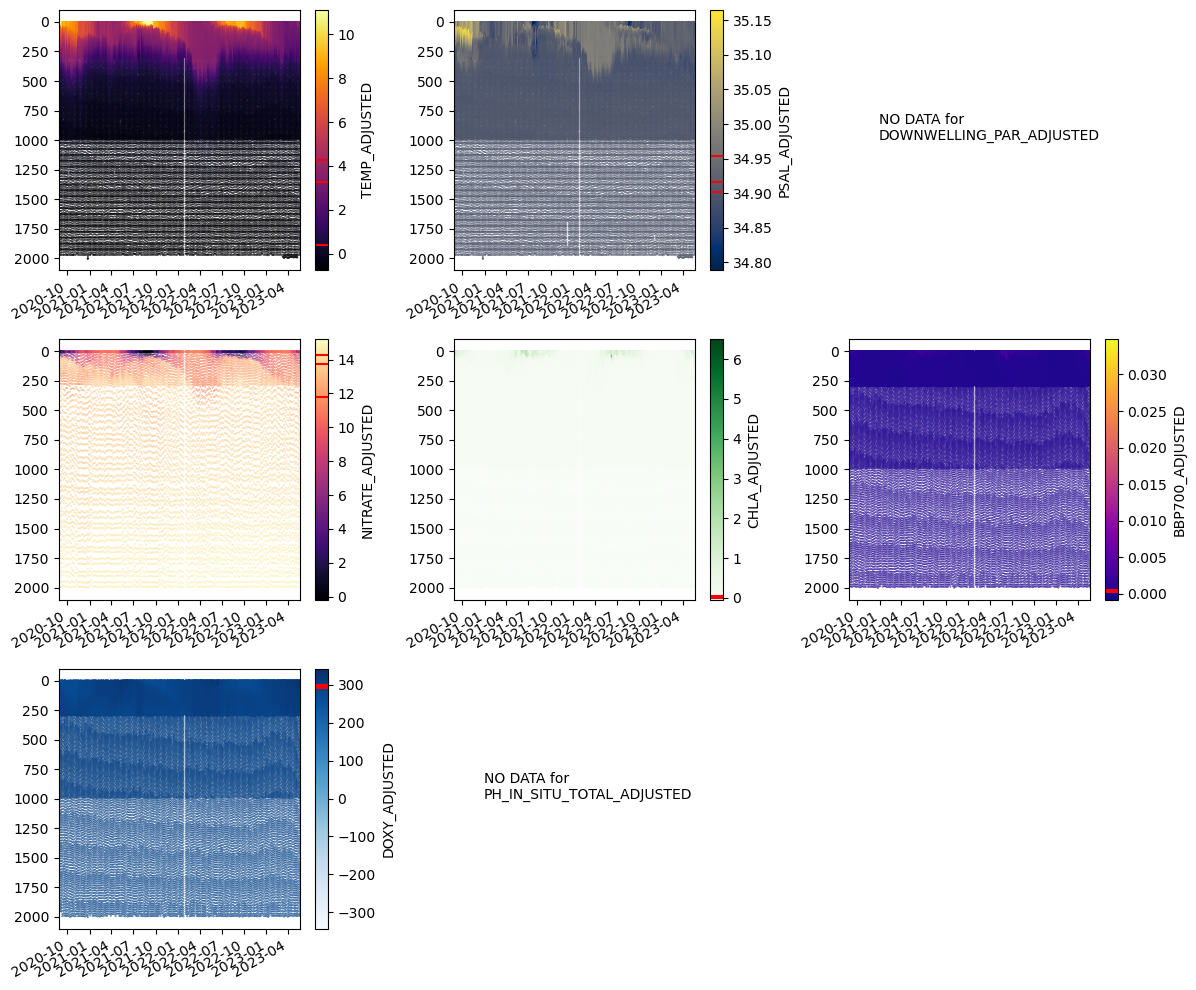

In [9]:
def plot_raw(vari_in,pres_in,juld_in,vari_name_in,cmap_in):
    for i in range(len(vari_in)): # loop over profiles
        if np.any(np.isfinite(vari_in[i])): # ignore the profile with all NaNs
            plt.scatter(np.full(len(pres_in[i]),juld_in[i]),pres_in[i],c=vari_in[i],s=0.1,cmap=cmap_in,
                        vmin=np.nanmin(np.concatenate(vari_in)),
                        vmax=np.nanmax(np.concatenate(vari_in))
                       )
    plt.gca().invert_yaxis()
    cbar = plt.colorbar()
    cbar.set_label(vari_name_in)
    vari_ptile = [np.nanpercentile(np.concatenate(vari_in),25),
                  np.nanpercentile(np.concatenate(vari_in),50),
                  np.nanpercentile(np.concatenate(vari_in),75)
                 ]
    cbar.ax.hlines(vari_ptile,xmin=0,xmax=1,color='r') # draw percentiles
    plt.gcf().autofmt_xdate() # automatically format date
    plt.xlim(np.min(juld),np.max(juld)) # align the date range across all variables

plt.figure(figsize=(12,10))
for j in range(len(varis)): # loop over variables
    plt.subplot(3,3,j+1)
    if len(raw[varis[j]]) and np.any(np.isfinite(np.concatenate(raw[varis[j]]))): # if finite values exit
        plot_raw(raw[varis[j]],pres,juld,vars_original[j],cmap_vars[j])
    else:
        plt.text(0.1,0.5,'NO DATA for \n'+vars_original[j])
        plt.axis('off')
plt.tight_layout()
plt.savefig(str(wmoid)+'/fig-raw-'+str(wmoid),dpi=300,bbox_inches='tight')

### Plotting the good data

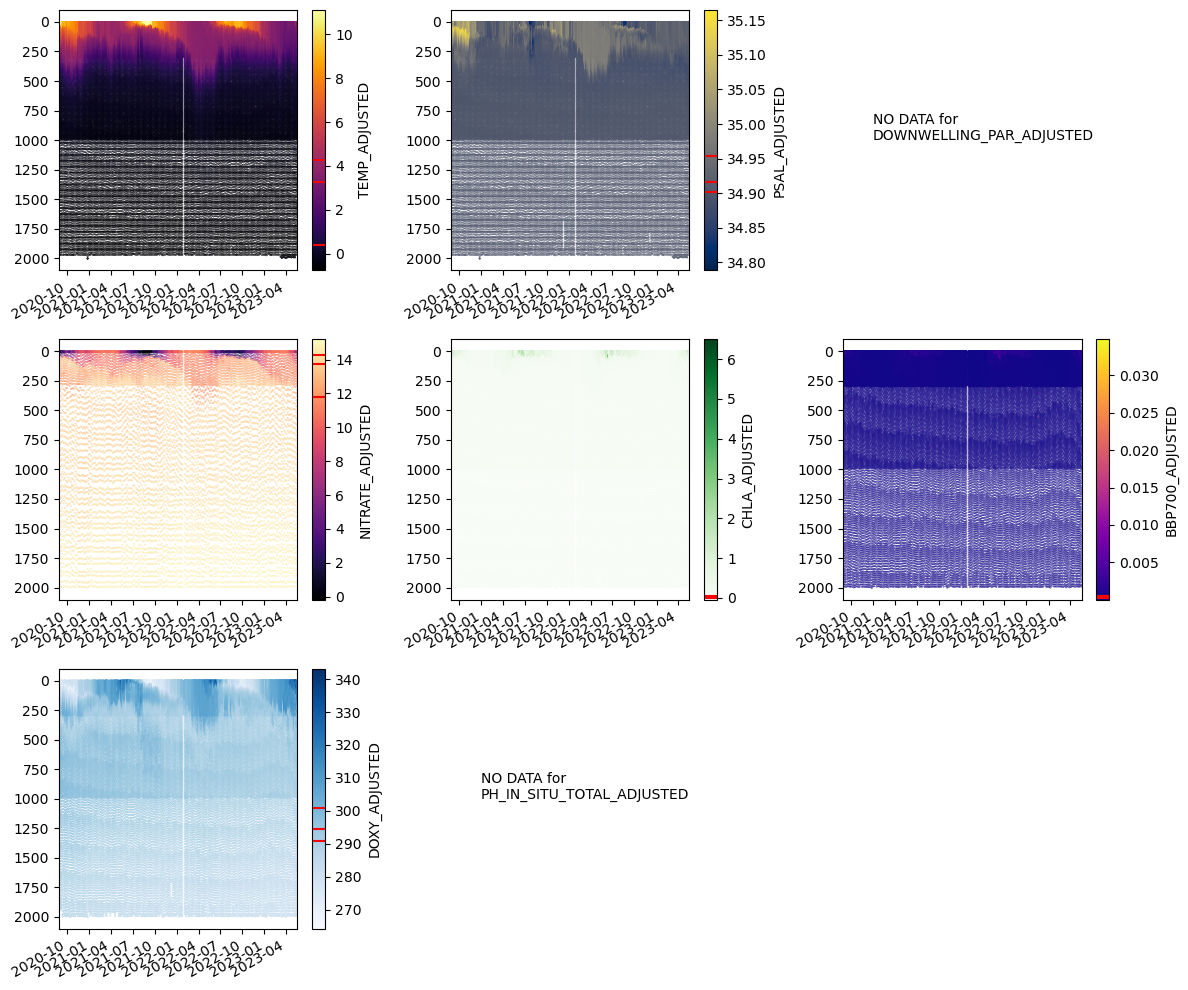

In [10]:
plt.figure(figsize=(12,10))
for j in range(len(varis)): # loop over variables
    plt.subplot(3,3,j+1)
    if len(qc_valid[varis[j]]) and np.any(np.isfinite(np.concatenate(qc_valid[varis[j]]))): # if finite values exit
        plot_raw(qc_valid[varis[j]],pres_qc_valid[varis[j]],juld,vars_original[j],cmap_vars[j])
    else:
        plt.text(0.1,0.5,'NO DATA for \n'+vars_original[j])
        plt.axis('off')
plt.tight_layout()
plt.savefig(str(wmoid)+'/fig-good-'+str(wmoid),dpi=300,bbox_inches='tight')

### Smoothing

/Users/hakaseh/miniconda3/envs/eat/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hakaseh/miniconda3/envs/eat/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


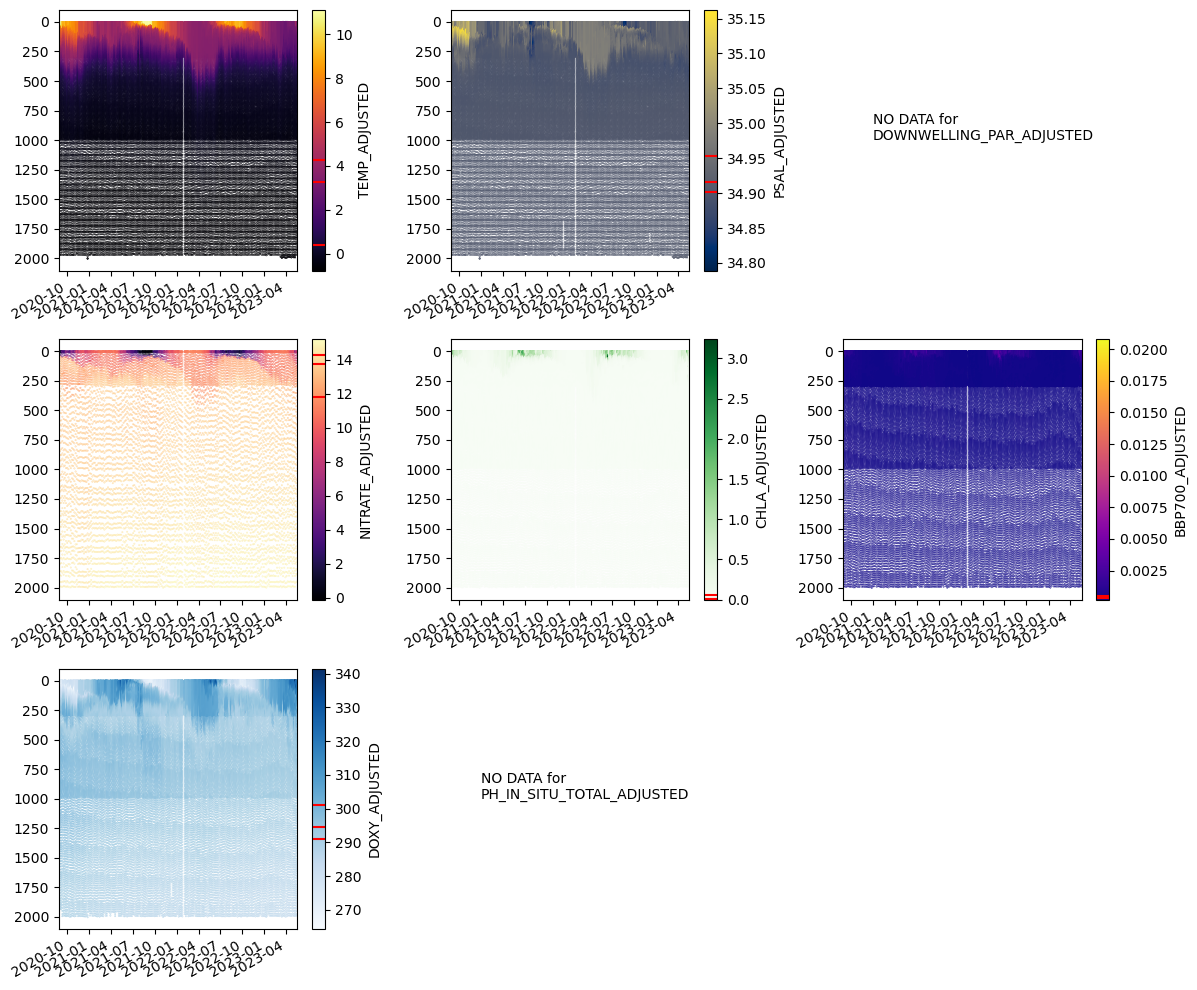

In [11]:
# median filter that ignores NaNs
def nanmedian_filter(values):
    valid_values = values[~np.isnan(values)]
    # set to median if valid values exit, set to NaN otherwise
    return np.median(valid_values) if len(valid_values) > 0 else np.nan

# define lists
smooth = {f"{var}": [] for var in varis} # smoothed data
pres_res = {f"{var}": [] for var in varis} # vertical resolution
pres_mid = {f"{var}": [] for var in varis} # midpoint depth at which vertical resolutions are defined

# Compute and assign smoothed values
for j in range(len(varis)): # loop over variables
    for i in range(len(qc_valid[varis[j]])): # loop over profiles
        # calculate vertical resolution
        pres_res[varis[j]].append(np.diff(pres_qc_valid[varis[j]][i]))
        pres_mid[varis[j]].append((pres_qc_valid[varis[j]][i][:-1] + pres_qc_valid[varis[j]][i][1:]) / 2) # 深度の解像度を計算
        pres_res_med = np.median(pres_res[varis[j]][-1])
        # window size
        if pres_res_med >= 3:
            nsmooth = 5
        elif pres_res_med <= 1:
            nsmooth = 11
        else:
            nsmooth = 7
        # apply median filter
        smooth[varis[j]].append(generic_filter(
            qc_valid[varis[j]][i],nanmedian_filter,size=nsmooth,mode='nearest')
                              )

# Plot
plt.figure(figsize=(12,10))
for j in range(len(varis)): # loop over variables
    plt.subplot(3,3,j+1)
    if len(smooth[varis[j]]) and np.any(np.isfinite(np.concatenate(smooth[varis[j]]))): # if finite values exit
        plot_raw(smooth[varis[j]],pres_qc_valid[varis[j]],juld,vars_original[j],cmap_vars[j])
    else:
        plt.text(0.1,0.5,'NO DATA for \n'+vars_original[j])
        plt.axis('off')
plt.tight_layout()
plt.savefig(str(wmoid)+'/fig-smooth-'+str(wmoid),dpi=300,bbox_inches='tight')

### <span style="color:red">--- User input begins ---</span>

In [13]:
int_res = 5 # vertical resolution used for interpolation (in dbar)
int_dep0 = 1.0 # the shallowest depth
int_dep1 = 1000.0 # the deepest depth

### <span style="color:red">--- User input ends ---</span>

### Interpolation
- date is sorted for 2d interpolation
- Set negatives to zeros for all variables other than temperature.

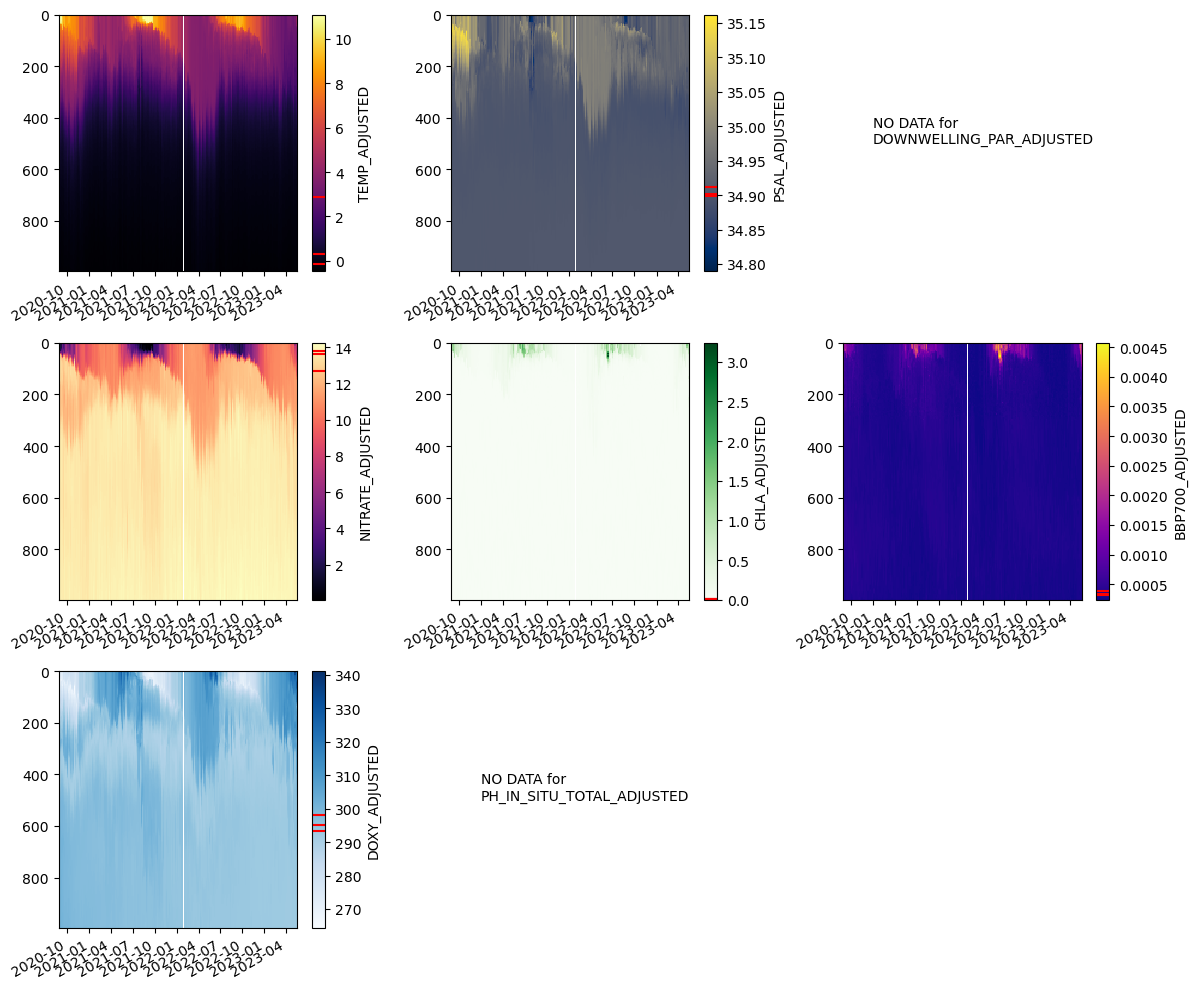

In [14]:
pres_int = np.arange(int_dep0,int_dep1,int_res) # depth grid for interpolation
data_int = {f"{var}": [] for var in varis} # interpolated data

def interpolate_argo(pres_in,pres_out,data_in,date,vari_name_in):
    data2d = np.full((len(date),len(pres_out)), np.nan) # create 2d array filled with NaNs
    for i in range(len(pres_in)):
        if np.any(np.isfinite(pres_in[i])): # ignore the profile with all NaNs
            f = scipy.interpolate.interp1d(x=pres_in[i],y=data_in[i],
                                           kind='linear',
                                           bounds_error=False,  
                                           fill_value=np.nan
                                          )
            data2d[i,:] = f(pres_out)
    return np.float32(data2d) # single precision is sufficient

# function to plot the interpolated data (2d array)
def plot_int(vari_in,pres_in,juld_in,vari_name_in,cmap_in):
    X, Y = np.meshgrid(juld_in,pres_in, indexing='ij')  # (time, depth)
    if np.any(np.isfinite(vari_in)): # check at least one value exits
        plt.pcolormesh(X,Y,vari_in,vmin=np.nanmin(vari_in),vmax=np.nanmax(vari_in),cmap=cmap_in)
    else: # all values are NaNs, which seems weird
        print('all interpolated values are NaN? CHECK')
    cbar = plt.colorbar()
    cbar.set_label(vari_name_in)
    vari_ptile = [np.nanpercentile(vari_in,25),
                  np.nanpercentile(vari_in,50),
                  np.nanpercentile(vari_in,75)
                 ]
    cbar.ax.hlines(vari_ptile,xmin=0,xmax=1,color='r') # draw percentiles
    plt.gcf().autofmt_xdate() # automatically format date
    plt.xlim(np.min(juld),np.max(juld)) # align the date range across all variables
    plt.ylim(0,np.max(pres_in)) # align the depth range across all variables
    plt.gca().invert_yaxis()

# Interpolate and plot
plt.figure(figsize=(12,10))
for j in range(len(varis)): # loop over variables
    plt.subplot(3,3,j+1)
    if len(smooth[varis[j]]) and np.any(np.isfinite(np.concatenate(smooth[varis[j]]))): # if finite values exit
        data_int[varis[j]] = interpolate_argo(pres_qc_valid[varis[j]],pres_int,smooth[varis[j]],juld,vars_original[j])
        if varis[j] != 'temp': # if not temperature
            data_int[varis[j]][data_int[varis[j]]<0] = 0 # set negatives to zeros
        plot_int(data_int[varis[j]],pres_int,juld,vars_original[j],cmap_vars[j])        
    else:
        plt.text(0.1,0.5,'NO DATA for \n'+vars_original[j])
        plt.axis('off')
plt.tight_layout()
plt.savefig(str(wmoid)+'/fig-int-'+str(wmoid),dpi=300,bbox_inches='tight')

### Store as an xarray dataset

In [15]:
# Initialize dictionary to hold DataArrays
data_vars = {}

# Loop to generate DataArrays
for i in range(len(varis)):
    if len(data_int[varis[i]]): # continue if data exist
        data_array = xr.DataArray(
            data_int[varis[i]],
            coords={
                'time': ('time', juld), #, {'units': 'days since 1950-01-01'}),
                'depth': ('depth', pres_int, {'units': 'dbar'})  # or 'meters' if it's depth below sea surface
            },            
            dims=['time', 'depth'],
            attrs=ds[vars_original[i]].attrs # copy the input file attributes
        )
        data_vars[vars_original[i]+'_AR'] = data_array # adding the array to the dataset (AR: Analysis-Ready)
    else: # skip if data are empty
        print(vars_original[i],'is empty so not adding to the file')

# add longitude and latitude as additonal variables in case of potential use
data_vars['LONGITUDE'] = xr.DataArray(lon,coords={'time': ('time', juld)},dims=['time'],attrs=ds['LONGITUDE'].attrs)
data_vars['LATITUDE'] = xr.DataArray(lat,coords={'time': ('time', juld)},dims=['time'],attrs=ds['LATITUDE'].attrs)

# Create Dataset from all variables
ds_int = xr.Dataset(data_vars)

print(ds_int)

DOWNWELLING_PAR_ADJUSTED is empty so not adding to the file
PH_IN_SITU_TOTAL_ADJUSTED is empty so not adding to the file
<xarray.Dataset> Size: 966kB
Dimensions:              (time: 200, depth: 200)
Coordinates:
  * time                 (time) datetime64[ns] 2kB 2020-08-26T11:31:59.999999...
  * depth                (depth) float64 2kB 1.0 6.0 11.0 ... 986.0 991.0 996.0
Data variables:
    TEMP_ADJUSTED_AR     (time, depth) float32 160kB nan 11.04 ... -0.3297
    PSAL_ADJUSTED_AR     (time, depth) float32 160kB nan 35.02 ... 34.9 34.9
    NITRATE_ADJUSTED_AR  (time, depth) float32 160kB nan 1.633 ... 13.95 13.96
    CHLA_ADJUSTED_AR     (time, depth) float32 160kB 1.425 1.43 ... 0.006686
    BBP700_ADJUSTED_AR   (time, depth) float32 160kB 0.001598 ... 0.0003201
    DOXY_ADJUSTED_AR     (time, depth) float32 160kB nan nan nan ... 293.1 293.1
    LONGITUDE            (time) float64 2kB -0.6401 -0.6897 ... -4.414 -4.238
    LATITUDE             (time) float64 2kB 67.49 67.34 67.17 ... 67

### Extra
- Non-Photochemical Quenching (NPQ) correction for chlrophyll-a
- For all profiles collected during daytime, check whether NPQ correction was done (blue) or not (orange). It is unclear why some daytime profiles were NPQ corrected while others are not for some float, but it is possible that the correction was not done when some variables (e.g. T/S/CHLA) contained bad data.
- Mixed layer depth based on the 0.03 kg m-3 threshold relative to the reference density at 10 dbar.
- Sigma0, spiciness, and oxygen saturation concentration at 0 dbar calculated using GSW-Python.

Total number of NPQ-corrected profiles in this step: 1


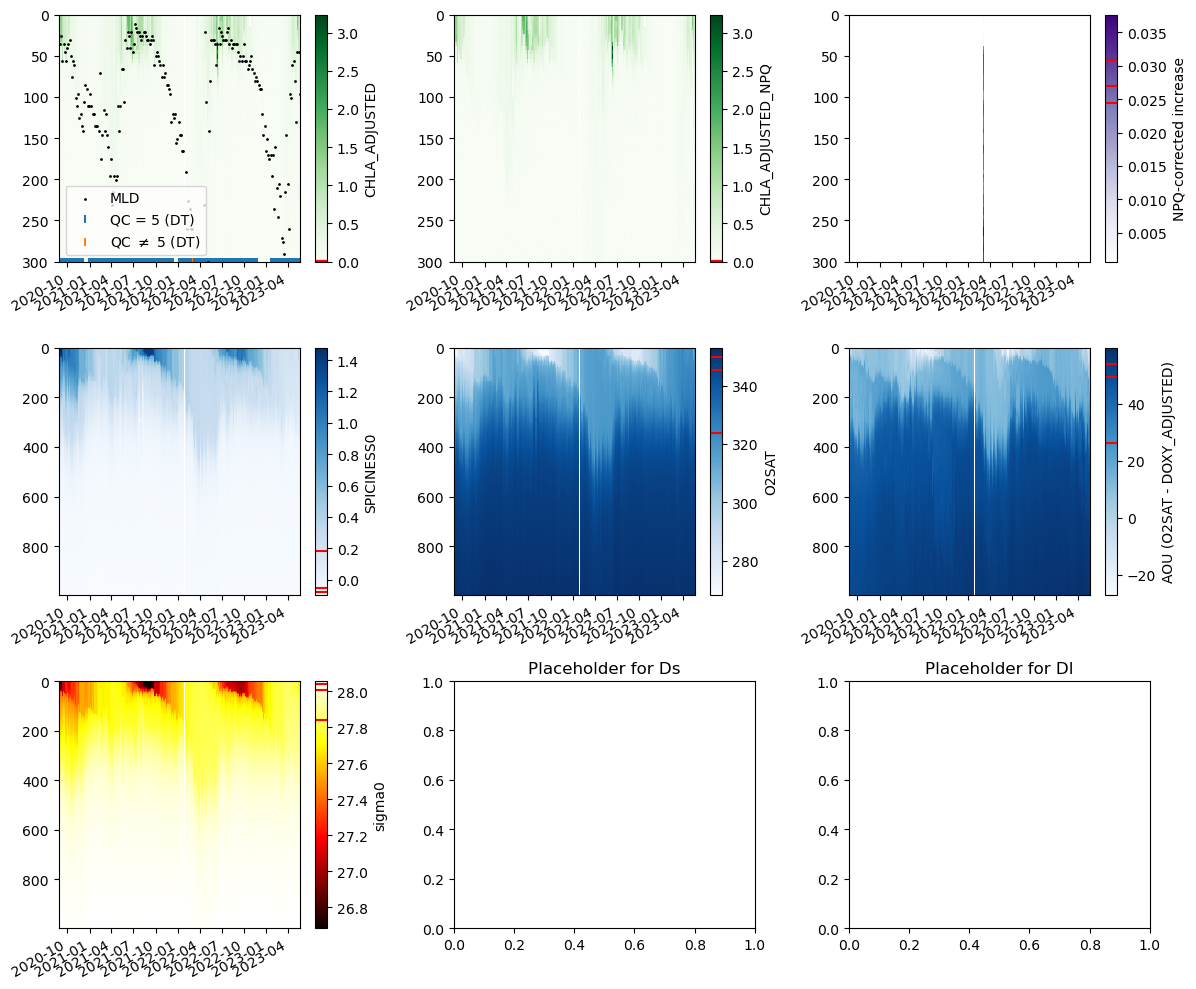

In [16]:
# Define empty lists
mld = [] # mixed layer depth
sigma0 = [] # potential density anomaly
chla_npq = data_int['chla'].copy() # NPQ corrected
count_npq = 0 # number of NPQ correction applied here
spiciness0 = [] 
O2sol = [] 
y_bottom = 300 # depth limit for plotting

# MLD calculation
if len(data_int['temp']) and len(data_int['psal']):
    for i in range(len(data_int['temp'])): # loop over profiles        
        if np.any(~np.isnan(data_int['temp'][i,:])) and np.any(~np.isnan(data_int['psal'][i,:])): # if good data exists
            # Absolute Salinity
            SA = gsw.SA_from_SP(data_int['psal'][i,:], pres_int, lon[i], lat[i])        
            # Conservative Temperature
            CT = gsw.CT_from_t(SA, data_int['temp'][i,:], pres_int)
            # Saturation oxygen concentration (umol/kg)
            O2sol.append(gsw.O2sol(SA,CT,pres_int,lon[i],lat[i]))
            # Spiciness referenced to a pressure level of 0 dbar, i.e. at surface (kg/m^3)
            spiciness0.append(gsw.spiciness0(SA,CT))
            # Potential Density
            sigma0.append(gsw.sigma0(SA, CT))
            # Obtain sigma0 at 10 dbar based on linear interpolation
            sigma0_10 = np.interp(10, pres_int, sigma0[-1])
            for j in range(len(sigma0[-1])): # loop over samples
                if sigma0[-1][j] > sigma0_10 + 0.03:
                    mld.append(pres_int[j])
                    idx90 = np.argmin(np.abs(pres_int - 0.9*mld[-1])) # depth index closest to mld*0.9
                    if len(data_int['chla'] > 0):
                        if np.any(~np.isnan(data_int['chla'][i, :])) and daytime_valid[i] and not npq5_qc_valid[i]: # if good data exists, sun is above horizon, and qc != 5 (NPQ correction necessary and possible)
                            chla_npq[i,:idx90+1] = np.nanmax(chla_npq[i,:idx90+1]) # set the upper 90% mld to have uniform chla
                            count_npq += 1 # count the number of corrected profiles
                    break # stop at the first occurrence
            else: # if the threshold is never met
                mld.append(np.nan) # assign nan because MLD was not found
        else:
            mld.append(np.nan) # assign nan because no good temp and psal data exit
            sigma0.append([np.nan]*len(pres_int))
            O2sol.append([np.nan]*len(pres_int)) 
            spiciness0.append([np.nan]*len(pres_int))
else:
    print('Doing nothing as no temp and salt data exist (this should not happen...)')

print('Total number of NPQ-corrected profiles in this step:',count_npq)

# Add MLD as an additional variable
ds_int['MLD'] = xr.DataArray(mld,coords={'time': ('time', juld)},dims=['time'],
                                attrs={
                                'long_name': 'Mixed layer depth based on 0.03 kg m-3 density criterion',
                                'standard_name': 'mixed_layer_depth',
                                'units': 'm',
                                'valid_min': np.float32(0.0),
                                'valid_max': np.float32(1000.0)
                                }
                               )

# Add sigma0 as an additional variable
ds_int['sigma0'] = xr.DataArray(
    sigma0,
    coords={
        'time': ('time', juld),
        'depth': ('depth', pres_int, {'units': 'dbar'})
    },
    dims=['time', 'depth'],
    attrs={
        'long_name': 'Potential density anomaly (sigma-0)',
        'standard_name': 'sea_water_sigma_theta',
        'comment': 'Potential density anomaly referenced to 0 dbar. See TEOS-10 for details.',
        'units': 'kg/m^3 - 1000',  # or '1' (dimensionless, but often reported as "kg/m³ - 1000")
        'valid_min': np.float32(20.0),
        'valid_max': np.float32(30.0)
    }
)
# Add spiciness as an additional variable
ds_int['SPICINESS0'] = xr.DataArray(spiciness0,
                                   coords={'time': ('time', juld), 
                                           'depth': ('depth', pres_int, {'units': 'dbar'})
                                          },
                                   dims=['time', 'depth'],
                                   attrs={
                                    'long_name': 'Spiciness referenced to a pressure of 0 dbar',
                                    'standard_name': 'spiciness',
                                    'comment': 'see spiciness0 in https://teos-10.github.io/GSW-Python/gsw_flat.html',
                                    'units': 'kg m-3',
                                    'valid_min': np.float32(-100.0),
                                    'valid_max': np.float32(100.0)
                                    })

# Add oxygen saturation as an additional variable
ds_int['O2SOL'] = xr.DataArray(O2sol,
                               coords={'time': ('time', juld), 
                                       'depth': ('depth', pres_int, {'units': 'dbar'})
                                      },
                               dims=['time', 'depth'],
                               attrs={
                                'long_name': 'Oxygen saturation concentration',
                                'standard_name': 'moles_of_oxygen_per_unit_mass_in_sea_water',
                                'comment': 'see O2sol in https://teos-10.github.io/GSW-Python/gsw_flat.html',
                                'units': 'micromole/kg',
                                'valid_min': np.float32(-5.0),
                                'valid_max': np.float32(600.0)
                                })

# Visualize the calculated MLD and the effect of the NPQ correction.
plt.figure(figsize=(12,10))
plt.subplot(331)
plt.scatter(juld,ds_int['MLD'],zorder=3,s=1,c='k')
plt.scatter([],[],s=1,c='k',label='MLD')
if len(raw['chla']):
    for i in range(len(juld)):
        if daytime_valid[i]:
            if npq5_qc_valid[i]:
                plt.scatter(juld[i],y_bottom,marker='|',color='tab:blue',zorder=2)
            else:
                plt.scatter(juld[i],y_bottom,marker='|',color='tab:orange',zorder=2)
    plt.scatter([],[],marker='|',color='tab:blue',label=r"QC = 5 (DT)")
    plt.scatter([],[],marker='|',color='tab:orange',label=r"QC $\ne$ 5 (DT)")
    plt.legend()
else:
    print('CHLA_ADJUSTED is empty!')
plt.legend()
if count_npq > 0: # if NPQ correction was done
    plot_int(data_int['chla'],pres_int,juld,'CHLA_ADJUSTED','Greens')
    plt.ylim(y_bottom,0)
    plt.subplot(332)
    plot_int(chla_npq,pres_int,juld,'CHLA_ADJUSTED_NPQ','Greens')
    plt.ylim(y_bottom,0)
    plt.subplot(333)
    diff = chla_npq - data_int['chla']
    masked_diff = np.where(diff != 0, diff, np.nan)
    plot_int(masked_diff,pres_int,juld,'NPQ-corrected increase','Purples')
    plt.ylim(y_bottom,0)
plt.subplot(334)
plot_int(spiciness0,pres_int,juld,'SPICINESS0','Blues')
plt.subplot(335)
plot_int(O2sol,pres_int,juld,'O2SAT','Blues')
plt.subplot(336)
plot_int(O2sol-data_int['doxy'],pres_int,juld,'AOU (O2SAT - DOXY_ADJUSTED)','Blues')
plt.subplot(337)
plot_int(ds_int['sigma0'],pres_int,juld,'sigma0','hot')
plt.subplot(338)
plt.title('Placeholder for Ds')
plt.subplot(339)
plt.title('Placeholder for Dl')

plt.tight_layout()
plt.savefig(str(wmoid)+'/fig-extra-'+str(wmoid),dpi=300,bbox_inches='tight')

### Saving to netCDF

In [18]:
# If NPQ correction was done, replace the chlorophyll-a array
if count_npq > 0:
    ds_int['CHLA_ADJUSTED_AR'].values = chla_npq

# Add metadata
ds_int.attrs['title'] = 'Analysis-ready BGC-Argo float time series'
ds_int.attrs['institution'] = 'Japan Agency for Marine-Earth Science and Technology (JAMSTEC)'
ds_int.attrs['notes'] = 'Reference: Fujishima and Hayashida (2026): Jupyter Notebook for generating analysis-ready BGC-Argo float time series, Journal of Open Source Software'
ds_int.attrs['history'] = 'Created on ' + datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
# Save to NetCDF
ds_int.to_netcdf(str(wmoid)+'/AR'+str(wmoid)+'.nc')

print(ds_int)

<xarray.Dataset> Size: 2MB
Dimensions:              (time: 200, depth: 200)
Coordinates:
  * time                 (time) datetime64[ns] 2kB 2020-08-26T11:31:59.999999...
  * depth                (depth) float64 2kB 1.0 6.0 11.0 ... 986.0 991.0 996.0
Data variables:
    TEMP_ADJUSTED_AR     (time, depth) float32 160kB nan 11.04 ... -0.3297
    PSAL_ADJUSTED_AR     (time, depth) float32 160kB nan 35.02 ... 34.9 34.9
    NITRATE_ADJUSTED_AR  (time, depth) float32 160kB nan 1.633 ... 13.95 13.96
    CHLA_ADJUSTED_AR     (time, depth) float32 160kB 1.425 1.43 ... 0.006686
    BBP700_ADJUSTED_AR   (time, depth) float32 160kB 0.001598 ... 0.0003201
    DOXY_ADJUSTED_AR     (time, depth) float32 160kB nan nan nan ... 293.1 293.1
    LONGITUDE            (time) float64 2kB -0.6401 -0.6897 ... -4.414 -4.238
    LATITUDE             (time) float64 2kB 67.49 67.34 67.17 ... 67.34 67.23
    MLD                  (time) float64 2kB 36.0 36.0 26.0 ... 46.0 46.0 96.0
    sigma0               (time, dep